In [488]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [489]:
# Generating random cluster centers
def getCenters(numDims): 
    centers = []
    centers.append(np.random.rand(numDims))
    newCenter = np.random.rand(numDims) 
    newCenter = newCenter / np.linalg.norm(newCenter)
    while np.linalg.norm(newCenter-centers[0]) >= 1:
        newCenter = np.random.rand(numDims)
        newCenter = newCenter / np.linalg.norm(newCenter)
    centers.append(newCenter)
    newCenter = np.random.rand(numDims)
    newCenter = newCenter / np.linalg.norm(newCenter)
    while np.linalg.norm(newCenter-centers[0]) >= 1 and np.linalg.norm(newCenter-centers[1]) >= 1:
        newCenter = np.random.rand(numDims)
        newCenter = newCenter / np.linalg.norm(newCenter)
    centers.append(newCenter)
    return np.array(centers)

# Assign center classes 
def setCenterClasses(numCenters):
    centerClass = np.random.randint(0,2,numCenters)
    # Ensure at least one class present 
    if np.count_nonzero(centerClass) == 0:
        centerClass[np.random.randint(0,3)] = 1
    if np.count_nonzero(centerClass) == numCenters: 
        centerClass[np.random.randint(0,3)] = 0
    return centerClass

In [490]:
# Sample gaussian 
# Identity covariance 
def sampleGaussian(center):
    return np.random.normal(center, 1)

In [491]:
def MoG(numDims, numPoints):
    centers = getCenters(numDims)
    numCenters = centers.shape[0]
    centerClasses = setCenterClasses(numCenters)
    X = [] 
    y = []
    for i in range(0, numPoints):
        selectCenter = np.random.randint(0,numCenters)
        X.append(sampleGaussian(centers[selectCenter]))
        y.append(centerClasses[selectCenter])
    return np.array(X), np.array(y)

In [492]:
def splitData(X, y): 
    numTrain = int(X.shape[0] * 0.80)
    XTrain = X[:numTrain]
    yTrain = y[:numTrain]
    XTest = X[numTrain:]
    yTest = y[numTrain:]
    return XTrain, yTrain, XTest, yTest

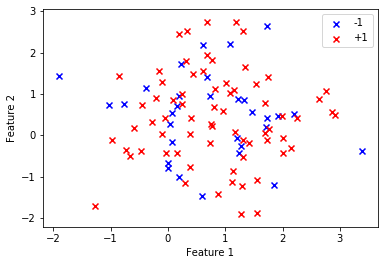

In [493]:
X, y = MoG(2,100)
colors = ['blue','red']
labels = ['-1','+1']
posIdx = np.argwhere(y==1)
negIdx = np.argwhere(y==0)
plt.scatter(X[negIdx,0],X[negIdx,1],\
    c=colors[0],label=labels[0],\
    marker='x')
plt.scatter(X[posIdx,0],X[posIdx,1],\
    c=colors[1],label=labels[1],\
    marker='x')
plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

XTrain, yTrain, XTest, yTest = splitData(X,y)

In [ ]:
dims = [2,10,100,1000]
for dim in dims: 
    X, y = MoG(dim,150)
    XTrain, yTrain, XTest, yTest = splitData(X,y)
    linClf = SGDClassifier()
    kNClf = KNeighborsClassifier() 
    numToAvg = 5 
    linScoreSum = 0 
    kNScoreSum = 0
    for i in range(0,numToAvg):
        linClf.fit(XTrain, yTrain)
        kNClf.fit(XTrain, yTrain)
        linScoreSum = linScoreSum + linClf.score(XTest, yTest)
        kNScoreSum = kNScoreSum + kNClf.score(XTest, yTest)
    linScore = linScoreSum / numToAvg
    kNScore = kNScoreSum / numToAvg
    print("Dimension: " + str(dim))
    print("Linear Accuracy: " + str(linScore))
    print("kN Accurcy: " + str(kNScore))

Dimension: 2
Linear Accuracy: 0.5666666666666667
kN Accurcy: 0.6666666666666666
Dimension: 10
Linear Accuracy: 0.5333333333333333
kN Accurcy: 0.6
